In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from setup import train, device

Usando dispositivo: cuda


In [52]:
MAX_LEN = 660000//12
SR = 22050
T0 = MAX_LEN/22050

X = []
y = []
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
for id, genre in enumerate(genres):
    for i in range(100):
        if not (i == 54 and genre == 'jazz'):
            x, _ = sf.read(f'../Data/genres_original/{genre}/{genre}.000{i:02}.wav')
            X.append(x[2*MAX_LEN:3*MAX_LEN])
            y.append(id)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=28, stratify=y
)
del X

print(f"Entrenamiento: {len(X_train)} pares")
print(f"Validación: {len(X_test)} pares")

Entrenamiento: 799 pares
Validación: 200 pares


In [4]:
F.one_hot(torch.tensor(3), 10)

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [9]:
class audiodataset(Dataset):
    def __init__(self, X, y):
        self.pairs = list(zip(X, y))
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        xs, ys = self.pairs[idx]

        return {
            'input': torch.tensor(xs).to(device, dtype=torch.float32),
            'target': F.one_hot(torch.tensor(ys), 10).to(device=device, dtype=torch.float32),
            'input_length': len(xs),
            'target_length': 10
        }

In [ ]:
train_dataset = audiodataset(X_train, y_train)
test_dataset = audiodataset(X_test, y_test)

train_dataset[2]

{'input': tensor([-0.5208, -0.3644, -0.1389,  ..., -0.0775, -0.0639,  0.0011],
        device='cuda:0', dtype=torch.float64),
 'target': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0',
        dtype=torch.float64),
 'input_length': 55000,
 'target_length': 10}

### Modelo naive

In [46]:
class modelo1(nn.Module):
    def __init__(self, input_size, p_drop = 0.5):
        super().__init__()
        self.capa1 = nn.Linear(input_size, 100, dtype=torch.float64)
        self.dropout = nn.Dropout(p=p_drop)
        self.capa2 = nn.Linear(100, 50, dtype=torch.float64)
        self.capa3 = nn.Linear(50, 10, dtype=torch.float64)
        self.relu = torch.relu

    def forward(self, input):
        out = self.relu(self.capa1(input))
        out = self.dropout(out)
        out = self.relu(self.capa2(out))
        out = self.capa3(out)
        return out.to(device)

In [47]:
# hiperparametros
INPUT_DIM = train_dataset[0]['input_length']
NUM_EPOCHS = 40
LEARNING_RATE = 0.001
P = 0.95

model = modelo1(INPUT_DIM, p_drop=P).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 5505660 parámetros


In [48]:
BATCH_SIZE = 8

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, criterion, NUM_EPOCHS)

Iniciando entrenamiento...
--------------------------------------------------
Época 5/40
  Pérdida Entrenamiento: 2.7316
  Pérdida Validación: 2.2608
  Empeorando
Época 10/40
  Pérdida Entrenamiento: 2.6103
  Pérdida Validación: 2.2757
  Empeorando
Época 15/40
  Pérdida Entrenamiento: 2.4668
  Pérdida Validación: 2.2946
  Empeorando
Época 20/40
  Pérdida Entrenamiento: 2.3541
  Pérdida Validación: 2.2907
  Empeorando
Época 25/40
  Pérdida Entrenamiento: 2.3390
  Pérdida Validación: 2.3038
  Empeorando
Época 30/40
  Pérdida Entrenamiento: 2.2564
  Pérdida Validación: 2.3023
  Empeorando
Época 35/40
  Pérdida Entrenamiento: 2.2124
  Pérdida Validación: 2.3114
  Empeorando
Época 40/40
  Pérdida Entrenamiento: 2.2665
  Pérdida Validación: 2.3025
  Empeorando
Entrenamiento completado!


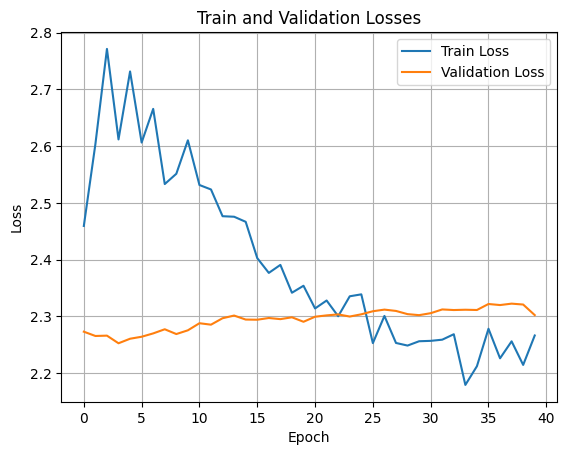

In [49]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
model.eval()
accur = 0
with torch.no_grad():
    for item in test_dataset:
        input = item['input']
        target = item['target']

        output = model.forward(input)
        pred = F.one_hot(torch.argmax(output), 10)

        accur += int(sum(target == pred) == 10)

accur /= len(test_dataset)
print(f'Accuracy con los datos de test {accur:.4f}')

Accuracy con los datos de test 0.1050


Con fourier

In [116]:
X_freq = []
y = []
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
for id, genre in enumerate(genres):
    for i in range(100):
        if not (i == 54 and genre == 'jazz'):
            x, _ = sf.read(f'../Data/genres_original/{genre}/{genre}.000{i:02}.wav')
            x_f = np.fft.rfft(x, n = 1024*4)
            X_freq.append(np.abs(x_f))
            y.append(id)

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_freq, y, test_size=0.2, random_state=28, stratify=y
)

print(f"Entrenamiento: {len(X_train)} pares")
print(f"Validación: {len(X_test)} pares")

train_dataset = audiodataset(X_train, y_train)
test_dataset = audiodataset(X_test, y_test)

Entrenamiento: 799 pares
Validación: 200 pares


In [118]:
train_dataset[0]

{'input': tensor([4.6283e+00, 4.0235e+00, 2.6956e+00,  ..., 4.2314e-03, 3.6122e-03,
         2.3499e-03], device='cuda:0'),
 'target': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0'),
 'input_length': 2049,
 'target_length': 10}

In [107]:
class modelo1(nn.Module):
    def __init__(self, input_size, d, p_drop = 0.5):
        super().__init__()
        self.capa1 = nn.Linear(input_size, d[0])
        self.bn1 = nn.BatchNorm1d(d[0])
        self.capa2 = nn.Linear(d[0], d[1])
        self.bn2 = nn.BatchNorm1d(d[1])
        self.capa3 = nn.Linear(d[1], d[2])
        self.bn3 = nn.BatchNorm1d(d[2])
        self.capa4 = nn.Linear(d[2], d[3])
        self.bn4 = nn.BatchNorm1d(d[3])
        self.capa5 = nn.Linear(d[3], 10)
        self.dropout = nn.Dropout(p=p_drop)
        self.gelu = nn.GELU()

    def forward(self, input):
        out = self.capa1(input)
        out = self.bn1(out)
        out = self.gelu(out)
        out = self.dropout(out)
        
        out = self.capa2(out)
        out = self.bn2(out)
        out = self.gelu(out)
        out = self.dropout(out)

        out = self.capa3(out)
        out = self.bn3(out)
        out = self.gelu(out)
        out = self.dropout(out)

        out = self.capa4(out)
        out = self.bn4(out)
        out = self.gelu(out)
        out = self.dropout(out)

        return self.capa5(out)

In [119]:
class modelo2(nn.Module):
    def __init__(self, input_size, hidden_dims, output_size=10, p_drop=0.5):
        super().__init__()
        
        layers = []
        in_dim = input_size
        
        for out_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(p=p_drop))
            in_dim = out_dim

        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(in_dim, output_size)

    def forward(self, input):
        out = self.hidden_layers(input)
        return self.output_layer(out)

In [120]:
# hiperparametros
INPUT_DIM = train_dataset[0]['input_length']
NUM_EPOCHS = 200
LEARNING_RATE = 0.0001
P = 0.6
D = [1024, 512, 256, 128, 64]

model = modelo2(INPUT_DIM, hidden_dims=D, p_drop=P).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, criterion, NUM_EPOCHS)

Modelo creado con 2801098 parámetros
Iniciando entrenamiento...
--------------------------------------------------
Época 5/200
  Pérdida Entrenamiento: 2.3781
  Pérdida Validación: 2.2667
  Mejorando
Época 10/200
  Pérdida Entrenamiento: 2.3342
  Pérdida Validación: 2.2333
  Mejorando
Época 15/200
  Pérdida Entrenamiento: 2.3258
  Pérdida Validación: 2.2033
  Mejorando
Época 20/200
  Pérdida Entrenamiento: 2.2531
  Pérdida Validación: 2.1714
  Empeorando
Época 25/200
  Pérdida Entrenamiento: 2.2301
  Pérdida Validación: 2.1244
  Mejorando
Época 30/200
  Pérdida Entrenamiento: 2.1993
  Pérdida Validación: 2.0735
  Mejorando
Época 35/200
  Pérdida Entrenamiento: 2.1601
  Pérdida Validación: 2.0178
  Mejorando
Época 40/200
  Pérdida Entrenamiento: 2.1073
  Pérdida Validación: 1.9768
  Mejorando
Época 45/200
  Pérdida Entrenamiento: 2.0941
  Pérdida Validación: 1.9290
  Mejorando
Época 50/200
  Pérdida Entrenamiento: 2.0130
  Pérdida Validación: 1.8883
  Mejorando
Época 55/200
  Pérdida En

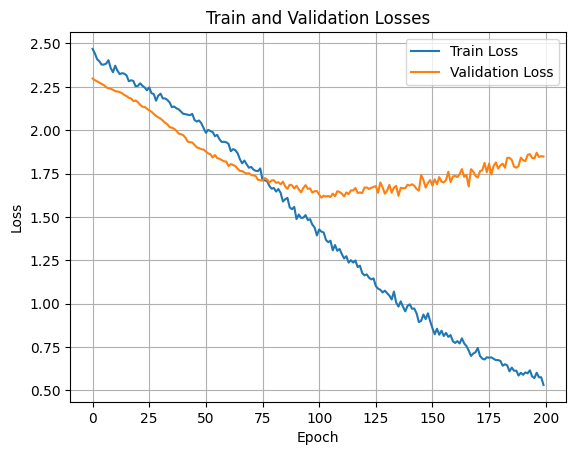

In [121]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [122]:
model.eval()
accur = 0
with torch.no_grad():
    for item in test_dataset:
        input = item['input'].unsqueeze(0)
        target = item['target']

        output = model.forward(input)
        pred = F.one_hot(torch.argmax(output), 10)

        accur += int(sum(target == pred) == 10)

accur /= len(test_dataset)
print(f'Accuracy con los datos de test {accur:.4f}')

Accuracy con los datos de test 0.3800
